In [ ]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def WIS(X,y, quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]):
    #X is the matrix of trajectories
    #calculate quantiles
    Q = np.quantile(X,quantiles,axis=0)
    WIS = np.zeros(X.shape[1])
    for i in range(len(quantiles) // 2):
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[11] - y)
        
    return np.sum(WIS) / (len(quantiles) // 2 + 0.5)

In [4]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


# proper vs strictly proper for SIR curve

In [5]:
# SIR Model in homogeneous single population
# input is the number of stochastic simulations to run, the transmissibility parameter, the recovery rate, 
# population size, and number of initially infected individuals
def SIR_model(nsim, beta, mu, pop, nseed):
    Sall = {}
    Iall = {}
    Rall = {}
    for sim in range(nsim):
        numsus = []
        numinf = []
        numrec = []
    
        numsus.append(pop)

        # initial conditions
        numsus[0] = pop-nseed
        numinf.append(nseed)
        numrec.append(0)
    
        t=0
        while numinf[t]> 0 :
            t+=1
        
            S = numsus[t-1]
            I = numinf[t-1]
            R = numrec[t-1]
            Nnew = S + I + R
            
            # simulate infection in the subpopulation    
            foi = 1 - ((1 - beta/Nnew)**(I) ) # force of infection
            
            ainf = np.random.binomial(S, min(1,foi)) # transmission
            arec = np.random.binomial(I, min(1,mu)) # recovery
            
            # update compartments
            S = S - ainf 
            I = I + ainf - arec
            R = R + arec
        
            # create time series of compartment counts
            numsus.append(S)
            numinf.append(I)
            numrec.append(R)
       
        # save all simulations in a dictionary
        Sall[sim] = numsus
        Iall[sim] = numinf
        Rall[sim] = numrec
        
    return Sall, Iall, Rall



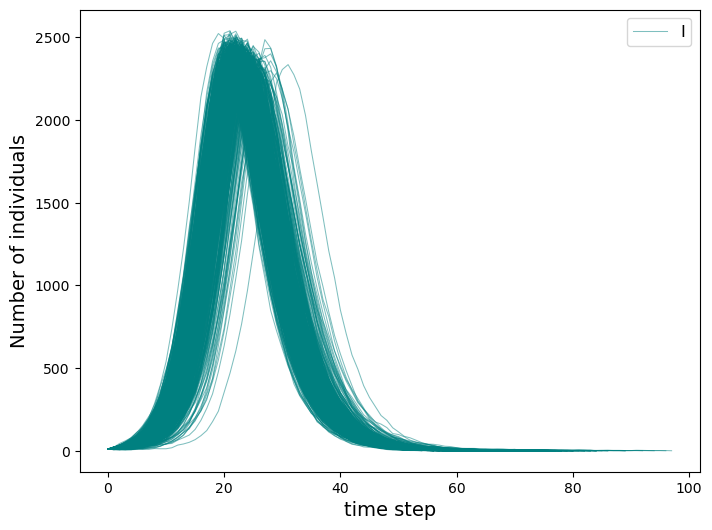

In [6]:
# example trajectories from SIR model
plt.figure(figsize=(8,6))
sim =1000
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)
for n in range(sim):
    plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)
    
plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

plt.legend(fontsize=12)
plt.xlabel('time step', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)


plt.show()

In [7]:
# only keep first 60 time steps
n=0
Ifilt = {}
for i in Iall.keys():
    if len(Iall[i])>=60:
        Ifilt[n] = Iall[i][0:60]
        n+=1

In [8]:
# save infection trajectories in dataframe
Idf = pd.DataFrame()

time = list(range(1, 61))

for it in range(1, 101):
    traj = Ifilt[it]
    
    for t in time:
        val = traj[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        
        Idf = pd.concat([Idf, newrow])
    

In [9]:
# plot of uncorrelated trajectories
plt.figure(figsize=(8,6))
for i in Ishift.trajectory_id.unique():
    if i<500:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.15)
        
for i in Idf.trajectory_id.unique():
    if i<500:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.15)
        
        
plt.xlim([0,60])

plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)

NameError: name 'Ishift' is not defined

<Figure size 800x600 with 0 Axes>

(0.0, 70.0)

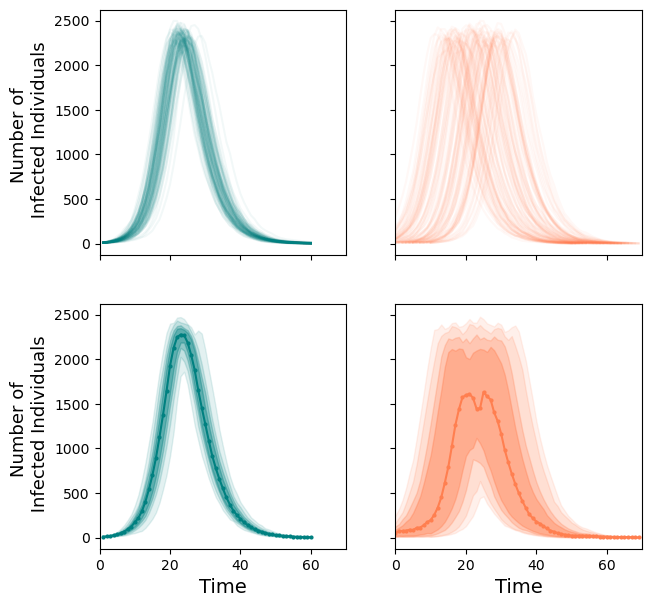

In [53]:
Ishift = Ishift.sort_values(by='time',ascending=True)

# plot all trajectories
fig,ax = plt.subplots(2,2, figsize=(7,7), sharey=True,sharex=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
        

plt.subplot(2,2,2)
for i in Ishift.trajectory_id.unique():
    if i<501:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Ishift.groupby('time')['I'].quantile(q[0]))
    qlow = list(Ishift.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Ishift.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(Ishift.groupby('time')['I'].quantile(.5))

plt.plot(Ishift.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.xlim([0,70])

In [6]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        d = Idf[Idf.trajectory_id==idx]
        d['time'] = d['time'] + 20
        
        maxtime = d.time.max()
        if maxtime<60:
            while maxtime<60:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                maxtime+=1
                
        mintime = d.time.min()
        if mintime>1:
            while mintime>1:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                mintime-=1
            

        Ishift = pd.concat([Ishift,d])

    Idf['Model'] = 'SIR'
    Ishift['Model'] = 'time shifted SIR'

    dftot = pd.concat([Idf, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [14]:
# compute energy score and WIS for SIR and uncorrelated model
numit =100

ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):
    
    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories(sim=800)

    SIRdf = dftot[dftot.Model=='SIR'].sort_values(by='time')
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    shiftdf = dftot[dftot.Model=='time shifted SIR'].sort_values(by='time')
    shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_shift.append(energyscore(shift_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_shift.append(WIS(shift_X,y))
    
    

In [15]:
ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id':range(numit)})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'time shifted SIR', 'value':ES_shift,
                                     'trajectory_id':range(numit)})])

WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':range(numit)})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'time shifted SIR', 'value':WIS_shift,
                                       'trajectory_id':range(numit)})])

Text(0, 0.5, 'Number of infectious individual')

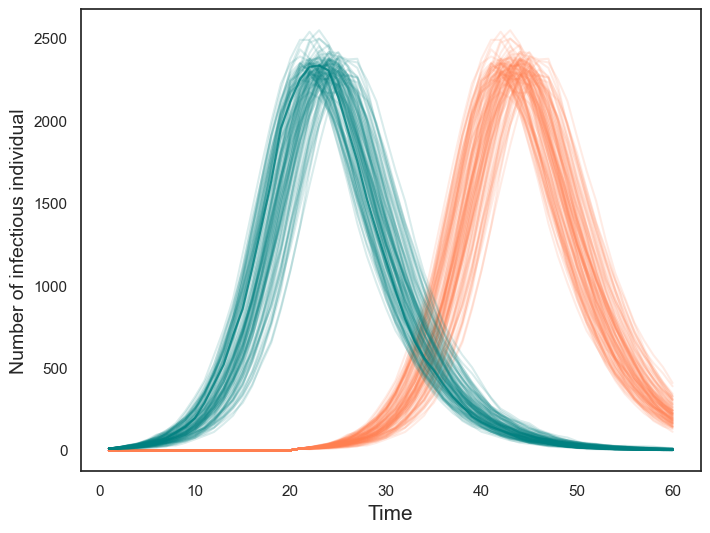

In [21]:
plt.figure(figsize=(8,6))

#dftot = get_SIR_trajectories_fixedshift(sim=800,shift=20)

Ishift = dftot[dftot.Model=='time shifted SIR'].sort_values(by='time')
Idf = dftot[dftot.Model=='SIR'].sort_values(by='time')

for i in Ishift.trajectory_id.unique():
    if i<500:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.15)
        
for i in Idf.trajectory_id.unique():
    if i<500:
        d = Idf[Idf.trajectory_id==i].sort_values(by='time')
        plt.plot(d.time, d.I, color='teal', alpha=.15)
plt.plot(d.time, d.I, color='teal', alpha=.8,label='No shift')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)

523.6713804946301
9136.793576448286
2416.7989597826086
55522.683944565215


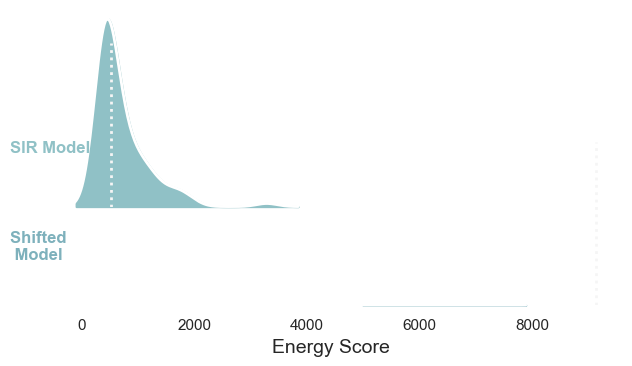

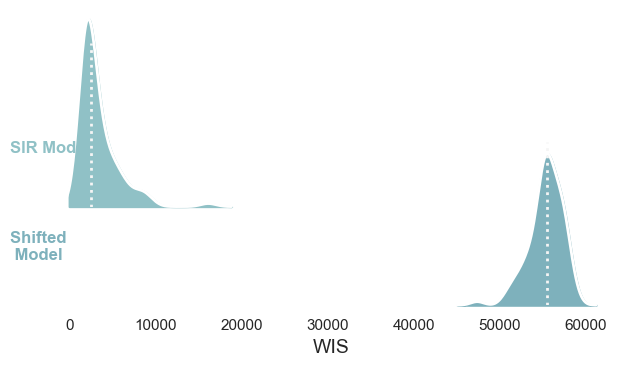

In [16]:
# plot distributions for energy score and WIS

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
dfs = [ESdf, WISdf]
scores = ['Energy Score', 'WIS']

i=1
#plt.subplots(1,2, figsize=(15,5))
for df in dfs:
    if i==1:
        maxi=5000
    else:
        maxi=110000
        
    df = df.copy()
    df['Model'] = df['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Shifted \n Model')
    #plt.subplot(1,2,i)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="Model", hue="Model", aspect=3.5, height=2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "value",
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5, clip = (-100,maxi))
    g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=1, clip = (-500,maxi))


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-.05, .3, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "value")

    # Define a function to plot the median
    def plot_median(data, color, label):
        median = np.median(data['value'])
        plt.axvline(median,ymin=0, ymax=.83, color='whitesmoke', linestyle=':', linewidth=2)
        print(median)

    # Apply the function to plot the median
    g.map_dataframe(plot_median)


    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    plt.xlabel(scores[i-1], fontsize=14)
    
   

  #  plt.savefig(f'../figs/dist_SIRtest_{scores[i-1]}.pdf')
    
    
    i+=1
    
    

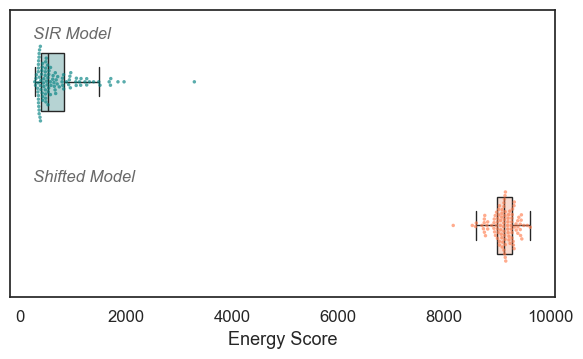

In [17]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = ESdf.copy()


g=sns.boxplot(x='value', y='Model', data=df,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=df,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(250,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

#plt.xlim([0,3500])    
    
plt.xlabel('Energy Score', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()

#plt.savefig('../figs/sir_test_ES_boxplots_1115.pdf')
plt.show()

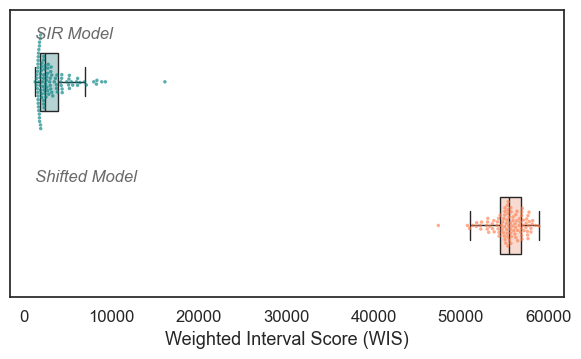

In [18]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = WISdf.copy()

g=sns.boxplot(x='value', y='Model', data=WISdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=WISdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

#plt.xlim([0,17500])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(1200,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Weighted Interval Score (WIS)', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()
#plt.savefig('../figs/sir_test_WIS_boxplots_1115.pdf')
plt.show()

In [19]:
dfSIR = ESdf[ESdf.Model=='SIR']
dfshifted = ESdf[ESdf.Model=='time shifted SIR'].rename(columns={'value':'ES_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio['ratio'] = dfratio['ES_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = WISdf[WISdf.Model=='SIR']
dfshifted = WISdf[WISdf.Model=='time shifted SIR'].rename(columns={'value':'WIS_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio_WIS['ratio'] = dfratio_WIS['WIS_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])

Text(-36.25, 0.5, '')

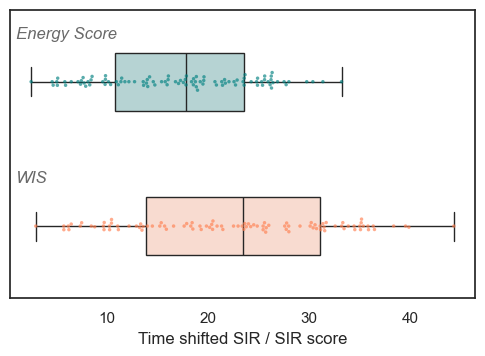

In [20]:
fig,ax = plt.subplots(figsize=(6,3.75))


palette = ['teal', 'coral']
g=sns.boxplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
sns.swarmplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['Energy Score', 'WIS']:
    plt.text(1,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1
    
    
plt.xlabel('Time shifted SIR / SIR score',fontsize=12)
plt.ylabel('')

In [270]:
dfshifted

,Model,ES_shifted,trajectory_id
0,time shifted SIR,1050.418673,1
1,time shifted SIR,609.140953,2
2,time shifted SIR,404.307965,3
3,time shifted SIR,543.339478,4
4,time shifted SIR,378.596482,5
...,...,...,...
95,time shifted SIR,432.386506,96
96,time shifted SIR,737.917775,97
97,time shifted SIR,924.811709,98
98,time shifted SIR,1002.396551,99


In [291]:
# save infection trajectories in dataframe
Idf = pd.DataFrame()

time = list(range(1, 61))

for it in range(1, 101):
    traj = Ifilt[it]
    
    for t in time:
        val = traj[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        
        Idf = pd.concat([Idf, newrow])
    

In [292]:
# reshuffle trajectories to create uncorrelated model

Ishift = pd.DataFrame()
for idx in Idf.trajectory_id.unique():
    d = Idf[Idf.trajectory_id==idx]
   # d['I'] = d['I'] + np.random.randint(-1000, high=1000)
    
   # d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)
    
    d['time'] = d['time'] + np.random.randint(-20, high=20)
    
    Ishift = pd.concat([Ishift,d])
    
   

Text(0, 0.5, 'Number of infectious individual')

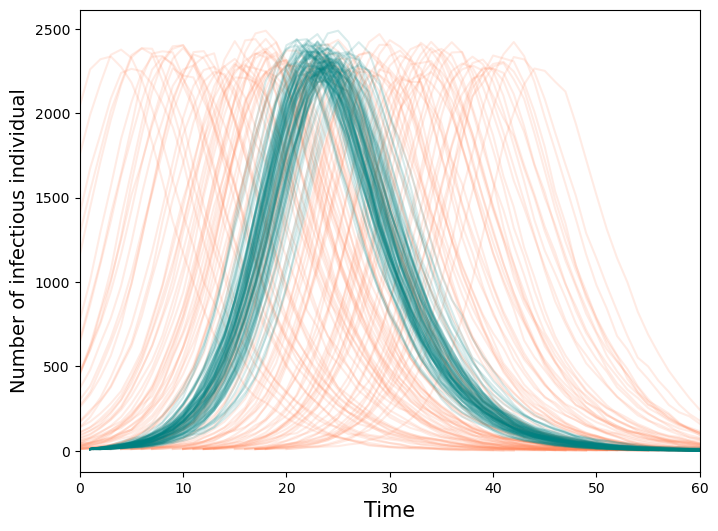

In [294]:
# plot of uncorrelated trajectories
plt.figure(figsize=(8,6))
for i in Ishift.trajectory_id.unique():
    if i<500:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.15)
        
for i in Idf.trajectory_id.unique():
    if i<500:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.15)
        
        
plt.xlim([0,60])

plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)

(0.0, 70.0)

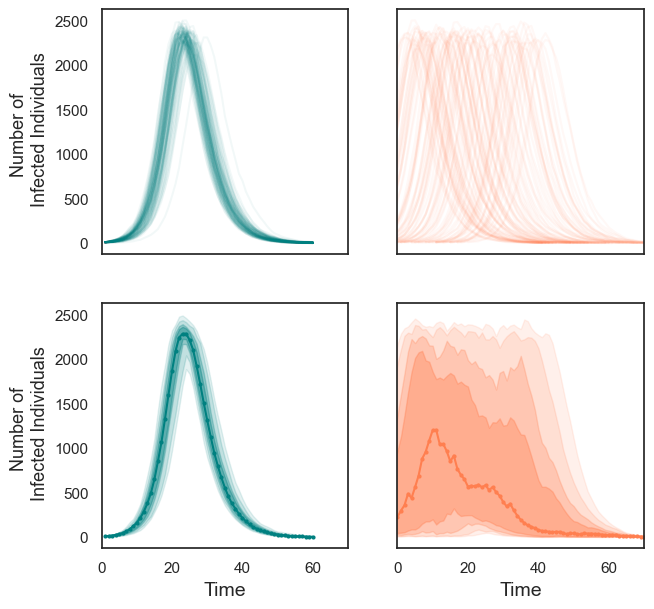

In [218]:
Ishift = Ishift.sort_values(by='time',ascending=True)

# plot all trajectories
fig,ax = plt.subplots(2,2, figsize=(7,7), sharey=True,sharex=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
        

plt.subplot(2,2,2)
for i in Ishift.trajectory_id.unique():
    if i<501:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Ishift.groupby('time')['I'].quantile(q[0]))
    qlow = list(Ishift.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Ishift.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(Ishift.groupby('time')['I'].quantile(.5))

plt.plot(Ishift.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.xlim([0,70])

In [22]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        d = Idf[Idf.trajectory_id==idx]
        d['time'] = d['time'] + np.random.randint(-20, high=20)
        
        maxtime = d.time.max()
        if maxtime<60:
            while maxtime<60:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                maxtime+=1
                
        mintime = d.time.min()
        if mintime>1:
            while mintime>1:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                mintime-=1
            

        Ishift = pd.concat([Ishift,d])

    Idf['Model'] = 'SIR'
    Ishift['Model'] = 'time shifted SIR'

    dftot = pd.concat([Idf, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [158]:
ESdf

,Model,value
0,SIR,403.450413
1,SIR,618.317168
2,SIR,385.708206
3,SIR,520.654794
4,SIR,472.983108
...,...,...
95,time shifted SIR,5451.475286
96,time shifted SIR,5783.813297
97,time shifted SIR,5554.911029
98,time shifted SIR,5922.562206


In [23]:
# compute energy score and WIS for SIR and uncorrelated model
numit =100

ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):
    
    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories(sim=800)

    SIRdf = dftot[dftot.Model=='SIR'].sort_values(by='time')
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    shiftdf = dftot[dftot.Model=='time shifted SIR'].sort_values(by='time')
    shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_shift.append(energyscore(shift_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_shift.append(WIS(shift_X,y))
    
    

In [24]:
ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id':range(numit)})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'time shifted SIR', 'value':ES_shift,
                                     'trajectory_id':range(numit)})])

WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':range(numit)})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'time shifted SIR', 'value':WIS_shift,
                                       'trajectory_id':range(numit)})])

582.3376089962037
2947.7504343891896
2621.608729347826
14440.631252173913


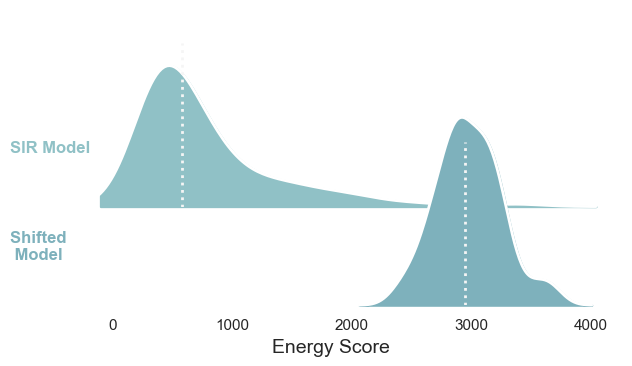

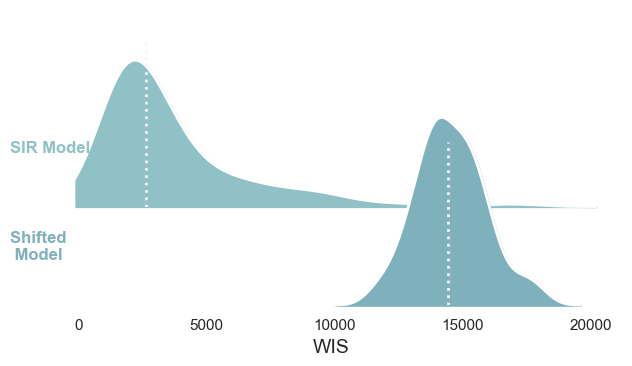

In [25]:
# plot distributions for energy score and WIS

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
dfs = [ESdf, WISdf]
scores = ['Energy Score', 'WIS']

i=1
#plt.subplots(1,2, figsize=(15,5))
for df in dfs:
    if i==1:
        maxi=10000
    else:
        maxi=110000
        
    df = df.copy()
    df['Model'] = df['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Shifted \n Model')
    #plt.subplot(1,2,i)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="Model", hue="Model", aspect=3.5, height=2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "value",
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5, clip = (-100,maxi))
    g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=1, clip = (-500,maxi))


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-.05, .3, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "value")

    # Define a function to plot the median
    def plot_median(data, color, label):
        median = np.median(data['value'])
        plt.axvline(median,ymin=0, ymax=.83, color='whitesmoke', linestyle=':', linewidth=2)
        print(median)

    # Apply the function to plot the median
    g.map_dataframe(plot_median)


    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    plt.xlabel(scores[i-1], fontsize=14)
    
   

  #  plt.savefig(f'../figs/dist_SIRtest_{scores[i-1]}.pdf')
    
    
    i+=1
    
    

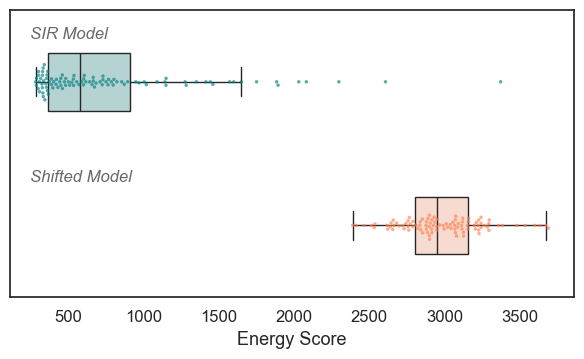

In [26]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = ESdf.copy()


g=sns.boxplot(x='value', y='Model', data=df,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=df,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(250,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

#plt.xlim([0,3500])    
    
plt.xlabel('Energy Score', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()

#plt.savefig('../figs/sir_test_ES_boxplots_1115.pdf')
plt.show()

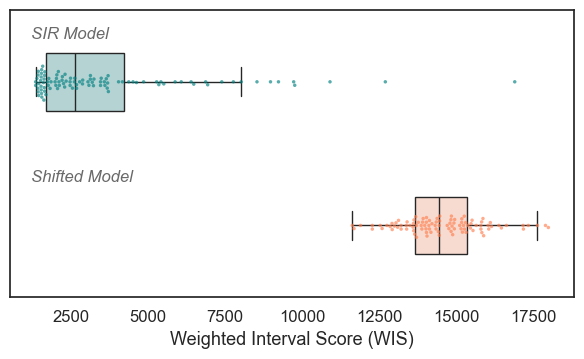

In [27]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = WISdf.copy()

g=sns.boxplot(x='value', y='Model', data=WISdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=WISdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

#plt.xlim([0,17500])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(1200,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Weighted Interval Score (WIS)', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()
#plt.savefig('../figs/sir_test_WIS_boxplots_1115.pdf')
plt.show()

In [28]:
dfSIR = ESdf[ESdf.Model=='SIR']
dfshifted = ESdf[ESdf.Model=='time shifted SIR'].rename(columns={'value':'ES_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio['ratio'] = dfratio['ES_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = WISdf[WISdf.Model=='SIR']
dfshifted = WISdf[WISdf.Model=='time shifted SIR'].rename(columns={'value':'WIS_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio_WIS['ratio'] = dfratio_WIS['WIS_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])

Text(-36.25, 0.5, '')

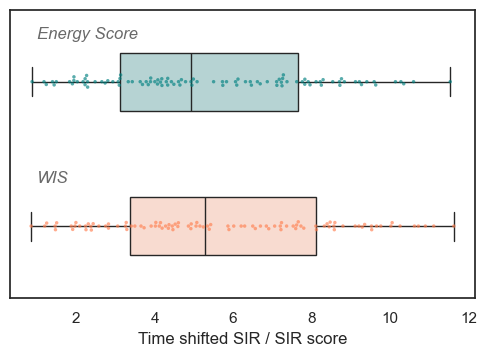

In [29]:
fig,ax = plt.subplots(figsize=(6,3.75))


palette = ['teal', 'coral']
g=sns.boxplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
sns.swarmplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['Energy Score', 'WIS']:
    plt.text(1,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1
    
    
plt.xlabel('Time shifted SIR / SIR score',fontsize=12)
plt.ylabel('')

# vary the fixed shift

In [30]:
def get_SIR_trajectories_fixedshift(sim=1000,shift=20):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])
            
             
     # time shifted SIR       

    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        d = Idf[Idf.trajectory_id==idx].copy()
        d['time'] = d['time'] + shift
        
        maxtime = d.time.max()
        if maxtime<60:
            while maxtime<60:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                maxtime+=1
                
        mintime = d.time.min()
        if mintime>1:
            while mintime>1:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                mintime-=1
            

        Ishift = pd.concat([Ishift,d])

    Idf['Model'] = 'SIR'
    Ishift['Model'] = 'time shifted SIR'

    dftot = pd.concat([Idf, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [31]:
# compute energy score and WIS for SIR and uncorrelated model
numit = 100

ES_all = pd.DataFrame()
WIS_all = pd.DataFrame()

for shift in [-20,-10,-5,0,5,10,20]:

    ES_SIR = []
    ES_shift = []
    WIS_SIR = []
    WIS_shift = []

    truth = []
    for i in range(numit):

        y=np.array([])
        while y.shape[0]<60:
            # generate observation vector as single instance of SIR model
            Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
            y = np.array(Iall[0][0:60]).astype(float) 

        dftot = get_SIR_trajectories_fixedshift(sim=800,shift=shift)

        SIRdf = dftot[dftot.Model=='SIR'].sort_values(by='time')
        SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 

        shiftdf = dftot[dftot.Model=='time shifted SIR'].sort_values(by='time')
        shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

        # calculate scores
        ES_SIR.append(energyscore(SIR_X ,y))
        ES_shift.append(energyscore(shift_X,y))
        WIS_SIR.append(WIS(SIR_X,y))
        WIS_shift.append(WIS(shift_X,y))


    ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id': list(range(len(ES_SIR)))})
    ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'time shifted SIR', 'value':ES_shift,
                                         'trajectory_id':list(range(len(ES_shift)))})])
    
    ESdf['shift'] = shift

    WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':list(range(len(WIS_SIR)))})
    WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'time shifted SIR', 'value':WIS_shift,
                                           'trajectory_id':list(range(len(WIS_shift)))})])
    WISdf['shift'] = shift
    
    ES_all = pd.concat([ES_all,ESdf])
    WIS_all = pd.concat([WIS_all,WISdf])

In [32]:
ES_all

,Model,value,trajectory_id,shift
0,SIR,696.937574,0,-20
1,SIR,341.059741,1,-20
2,SIR,3977.246375,2,-20
3,SIR,653.654048,3,-20
4,SIR,490.540588,4,-20
...,...,...,...,...
95,time shifted SIR,9371.921865,95,20
96,time shifted SIR,8472.136395,96,20
97,time shifted SIR,9337.348461,97,20
98,time shifted SIR,9213.945151,98,20


In [33]:
dfratio_all = pd.DataFrame()
for shift in [-20,-10,-5,0,5,10,20]:
    df_ES = ES_all[ES_all['shift']==shift]
    df_WIS = WIS_all[WIS_all['shift']==shift]
    
    dfSIR = df_ES[df_ES.Model=='SIR']
    dfshifted = df_ES[df_ES.Model=='time shifted SIR'].rename(columns={'value':'value_shifted'})

    dfratio = dfSIR.merge(dfshifted,on=['trajectory_id','shift'])
    dfratio['ratio'] = dfratio['value_shifted'] / dfratio['value']
    dfratio['score'] = 'Energy Score'

    dfSIR = df_WIS[df_WIS.Model=='SIR']
    dfshifted = df_WIS[df_WIS.Model=='time shifted SIR'].rename(columns={'value':'value_shifted'})

    dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id','shift'])
    dfratio_WIS['ratio'] = dfratio_WIS['value_shifted'] / dfratio_WIS['value']
    dfratio_WIS['score'] = 'WIS'

    dfratio = pd.concat([dfratio,dfratio_WIS])
    dfratio['shift'] = shift
    
    dfratio_all = pd.concat([dfratio_all, dfratio])

In [34]:
dfratio_all

,Model_x,value,trajectory_id,shift,Model_y,value_shifted,ratio,score
0,SIR,696.937574,0,-20,time shifted SIR,8639.871334,12.396909,Energy Score
1,SIR,341.059741,1,-20,time shifted SIR,8627.942466,25.297452,Energy Score
2,SIR,3977.246375,2,-20,time shifted SIR,9207.323405,2.315000,Energy Score
3,SIR,653.654048,3,-20,time shifted SIR,8734.492377,13.362561,Energy Score
4,SIR,490.540588,4,-20,time shifted SIR,8921.354236,18.186781,Energy Score
...,...,...,...,...,...,...,...,...
95,SIR,1864.547996,95,20,time shifted SIR,56531.144735,30.318954,WIS
96,SIR,7225.493330,96,20,time shifted SIR,50846.877185,7.037150,WIS
97,SIR,5067.238920,97,20,time shifted SIR,57562.676561,11.359772,WIS
98,SIR,1703.616298,98,20,time shifted SIR,55562.889720,32.614674,WIS


Text(0, 0.5, 'Time Shifted SIR / SIR score')

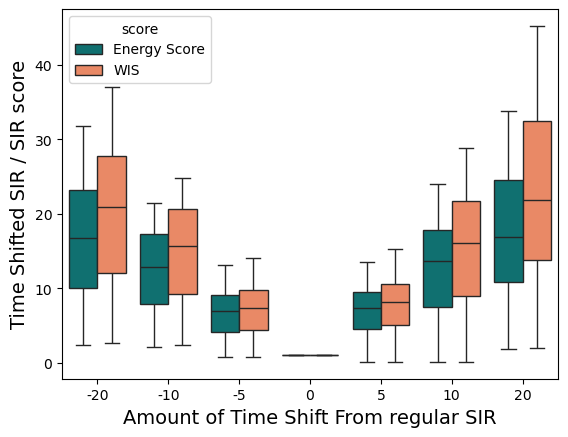

In [35]:
plt.style.use('default')
df = dfratio_all
palette = ['teal', 'coral']
sns.boxplot(x='shift',y='ratio',data=df,hue='score',showfliers=False,palette=palette)
plt.xlabel('Amount of Time Shift From regular SIR', fontsize=14)
plt.ylabel('Time Shifted SIR / SIR score', fontsize=14)


Text(0, 0.5, 'Time Shifted SIR / SIR score')

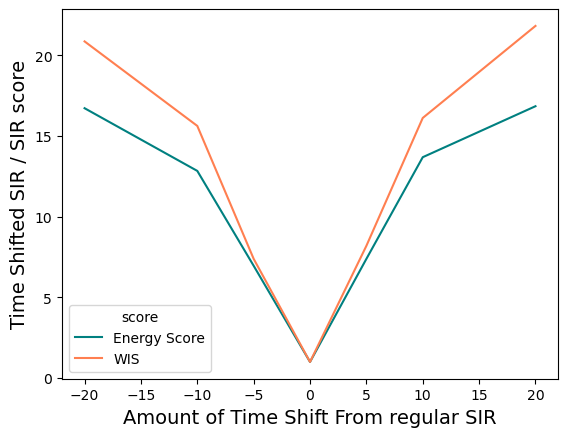

In [39]:
df = dfratio_all.groupby(['shift','score'])['ratio'].median().reset_index()

sns.lineplot(x='shift', y='ratio',data=df,hue='score',palette=palette,)
#plt.plot(df['shift'],df['ratio'],)
#plt.yscale('log')

plt.xlabel('Amount of Time Shift From regular SIR', fontsize=14)
plt.ylabel('Time Shifted SIR / SIR score', fontsize=14)

#plt.xlim([0, None])
#plt.ylim([0.9,1.5])

Text(0, 0.5, 'Number of infectious individual')

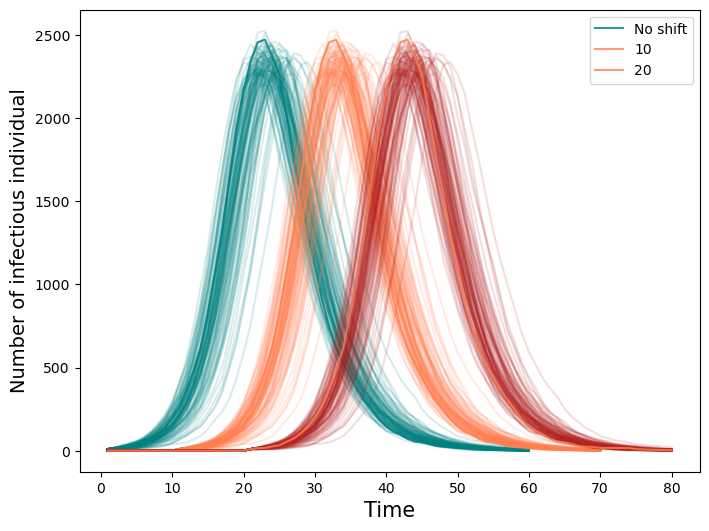

In [22]:
# plot of uncorrelated trajectories
plt.figure(figsize=(8,6))

dftot = get_SIR_trajectories_fixedshift(sim=800,shift=20)

Ishift = dftot[dftot.Model=='time shifted SIR'].sort_values(by='time')
Idf = dftot[dftot.Model=='SIR'].sort_values(by='time')

#for i in Ishift.trajectory_id.unique():
#    if i<500:
 #       d = Ishift[Ishift.trajectory_id==i]
  #      plt.plot(d.time, d.I, color='coral', alpha=.15)
        
for i in Idf.trajectory_id.unique():
    if i<500:
        d = Idf[Idf.trajectory_id==i].sort_values(by='time')
        plt.plot(d.time, d.I, color='teal', alpha=.15)
plt.plot(d.time, d.I, color='teal', alpha=.8,label='No shift')
        
colors = ['coral','firebrick'] 
j=0
for shift in [10,20]:        
    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        d = Idf[Idf.trajectory_id==idx]
        d['time'] = d['time'] + shift

        maxtime = d.time.max()
        if maxtime<60:
            while maxtime<60:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                maxtime+=1

        mintime = d.time.min()
        if mintime>1:
            while mintime>1:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                mintime-=1


        Ishift = pd.concat([Ishift,d])
        
    for i in Ishift.trajectory_id.unique():
        if i<500:
            d = Ishift[Ishift.trajectory_id==i].sort_values(by='time')
            plt.plot(d.time, d.I, color=colors[j], alpha=.15,)
    
    plt.plot(d.time, d.I, color='coral', alpha=.8,label=shift)

    j+=1

    
plt.legend()  

        
        
#plt.xlim([0,60])

plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)

In [71]:
def get_SIR_trajectories_fixedshift_twoway(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])
            
            
    Idfshift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        d = Idf[Idf.trajectory_id==idx].copy()
        
        d['time'] = d['time'] + 20
        
        maxtime = d.time.max()
        if maxtime<80:
            while maxtime<80:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                maxtime+=1
                
        mintime = d.time.min()
        if mintime>1:
            while mintime>1:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                mintime-=1
            

        Idfshift = pd.concat([Idfshift,d])

            
             
     # time shifted SIR       

    Ishift = pd.DataFrame()
    for idx in Idfshift.trajectory_id.unique():
        d = Idfshift[Idfshift.trajectory_id==idx].copy()
        
        if idx <=50:
            d['time'] = d['time'] + 20
        else:
            d['time'] = d['time'] - 20
        
        maxtime = d.time.max()
        if maxtime<80:
            while maxtime<80:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':maxtime+1,'I':0},index=[0])])
                maxtime+=1
                
        mintime = d.time.min()
        if mintime>1:
            while mintime>1:
                d = pd.concat([d,pd.DataFrame({'trajectory_id':idx,'time':mintime-1,'I':0},index=[0])])
                mintime-=1
            

        Ishift = pd.concat([Ishift,d])

    Idfshift['Model'] = 'SIR'
    Ishift['Model'] = 'time shifted SIR'

    dftot = pd.concat([Idfshift, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=80)]

    return dftot

In [72]:
# compute energy score and WIS for SIR and uncorrelated model
numit = 20

ES_all = pd.DataFrame()
WIS_all = pd.DataFrame()


ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):

    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        obs = get_SIR_trajectories_fixedshift_twoway(sim=150)
        obsI = obs[(obs.Model=='SIR') ]
        obsI = obsI[(obsI.trajectory_id==random.choice(obsI.trajectory_id.unique()))].sort_values(by='time')

        y = np.array(list(obsI.I)[0:80]).astype(float) 

    dftot = get_SIR_trajectories_fixedshift_twoway(sim=800)

    SIRdf = dftot[dftot.Model=='SIR'].sort_values(by='time')
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 

    shiftdf = dftot[dftot.Model=='time shifted SIR'].sort_values(by='time')
    shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_shift.append(energyscore(shift_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_shift.append(WIS(shift_X,y))


ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id': list(range(len(ES_SIR)))})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'time shifted SIR', 'value':ES_shift,
                                     'trajectory_id':list(range(len(ES_shift)))})])

ESdf['shift'] = shift

WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':list(range(len(WIS_SIR)))})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'time shifted SIR', 'value':WIS_shift,
                                       'trajectory_id':list(range(len(WIS_shift)))})])
WISdf['shift'] = shift

ES_all = pd.concat([ES_all,ESdf])
WIS_all = pd.concat([WIS_all,WISdf])

In [73]:
dfratio_all = pd.DataFrame()

df_ES = ES_all[ES_all['shift']==shift]
df_WIS = WIS_all[WIS_all['shift']==shift]

dfSIR = df_ES[df_ES.Model=='SIR']
dfshifted = df_ES[df_ES.Model=='time shifted SIR'].rename(columns={'value':'value_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id','shift'])
dfratio['ratio'] = dfratio['value_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = df_WIS[df_WIS.Model=='SIR']
dfshifted = df_WIS[df_WIS.Model=='time shifted SIR'].rename(columns={'value':'value_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id','shift'])
dfratio_WIS['ratio'] = dfratio_WIS['value_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])
dfratio['shift'] = shift

dfratio_all = pd.concat([dfratio_all, dfratio])

Text(0, 0.5, 'Time Shifted SIR / SIR score')

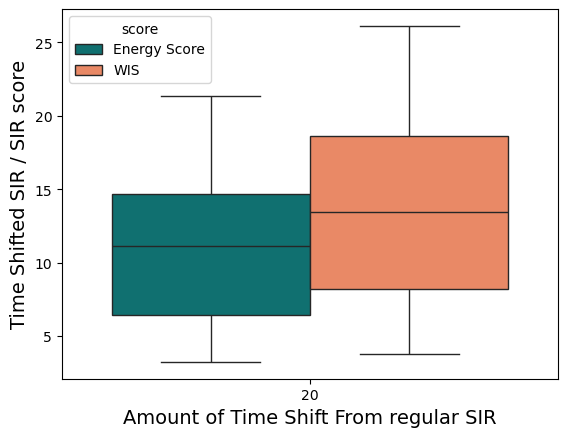

In [74]:
plt.style.use('default')
df = dfratio_all
palette = ['teal', 'coral']
sns.boxplot(x='shift',y='ratio',data=df,hue='score',showfliers=False,palette=palette)
plt.xlabel('Amount of Time Shift From regular SIR', fontsize=14)
plt.ylabel('Time Shifted SIR / SIR score', fontsize=14)
